In [0]:
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.optimizers import Adam 
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt
import traceback
from IPython import display
from datetime import datetime, timedelta, time, date

In [0]:
class Agent:
    def __init__(self, alpha, beta, gamma=0.99, n_actions=7,
                 layer1_size=32, layer2_size=16, input_dims=3):
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.input_dims = input_dims
        self.fc1_dims = layer1_size
        self.fc2_dims = layer2_size
        self.n_actions = n_actions
        
        self.actor, self.critic, self.policy = self.build_actor_critic_network()
        self.action_space = [i for i in range(self.n_actions)]
    
    def build_actor_critic_network(self):
        input_ = Input(shape=(self.input_dims,))
        delta = Input(shape=[1])
        dense1 = Dense(self.fc1_dims, activation='tanh')(input_)
        dense2 = Dense(self.fc2_dims, activation='tanh')(dense1)
        probs = Dense(self.n_actions, activation='softmax')(dense2)
        values = Dense(1, activation='linear')(dense2)
    
        def custom_loss(y_true, y_pred): #y_true:agent action took, y_pred: nn output
            out = K.clip(y_pred, 1e-8, 1-1e-8)
            log_lik = y_true*K.log(out)
        
            return K.sum(-log_lik*delta)
    
        actor = Model(inputs=[input_, delta], outputs=[probs])
        actor.compile(optimizer=Adam(lr=self.alpha), loss=custom_loss, experimental_run_tf_function=False)
        critic = Model(inputs=[input_], outputs=[values])
        critic.compile(optimizer=Adam(lr=self.beta), loss='mean_squared_error', experimental_run_tf_function=False)
        policy = Model(inputs=[input_], outputs=[probs])
        
        return actor, critic, policy
    
    def choose_action(self, state, t):
        probabilities = self.policy.predict(state.to_numpy())[0]
        action = np.random.choice(self.action_space, p=probabilities)
        return action
    
    def learn(self, state, action, reward, new_state, t):
        
        new_crtic_value = self.critic.predict(state.to_numpy())
        critic_value = self.critic.predict(state.to_numpy())
        
        target = reward + self.gamma * new_crtic_value
        delta = target - critic_value
        
        actions = np.zeros([1, self.n_actions])
        actions[np.arange(1), action] = 1.0
        
        self.actor.fit([state.to_numpy(), delta], actions, verbose=0)
        self.critic.fit(state.to_numpy(), target, verbose=0)

In [0]:
class State:
    def __init__(self, balance, position, prices, t):
        self._position = position
        self._balance = balance
        self._prices = prices
        self._t = t
        self._c = 0.05
        self._min_balance = 50
        self._penalty = 0.10 * 1000
    
    def get_position(self):
        return self._position
    
    def get_balance(self):
        return self._balance
    
    def get_price(self, t):
        return self._prices[t]
    
    def get_portfolio_value(self):
        return self._position + self._balance
    
    def get_lagged_prices(self, lag = 0):
        assert lag <= self._t, 'lag must be less than equal to t'
        return list(reversed(self._prices[self._t - lag: self._t + 1]))
    
    def update_state(self, action):
        # how will transaction cost affect adj action (add it to price for buying)
        # how will transaction cost affect reward
        # how will transction cost affect balance
        action = action-3
        r = self.get_price(self._t+1)/self.get_price(self._t) - 1
        max_shares_sell = self.get_position() // self.get_price(self._t)
        max_shares_buy = (self.get_balance() - self._min_balance )// (self.get_price(self._t) + self._c) # min cash balance
        adj_action = max(action, -max_shares_sell) if action < 0 else min(action, max_shares_buy)
        transaction_cost = abs(adj_action) * self._c
        new_state = State(self.get_balance() - adj_action * (self.get_price(self._t)) - transaction_cost, \
                          (self.get_position() + adj_action * self.get_price(self._t)) * (1 + r), \
                          self._prices, self._t + 1)
        stock_return = new_state.get_portfolio_value() - self.get_portfolio_value() 
        overnight_penalty = self._penalty if self._t == 58 else 0
        reward = stock_return - transaction_cost - overnight_penalty
        return new_state, reward

    def to_numpy(self):
        return np.array([self.get_balance(), self.get_position(), self.get_price(self._t)]).reshape((1,3))
    
    def __str__(self):
        return 'Balance: %.2f; Dollar Position: %.2f; Price: %.2f; Time %d' % (self._balance, self._position, self._prices[self._t], self._t)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Text(0.5, 1.0, 'Stock Price with Flat Behavior ')

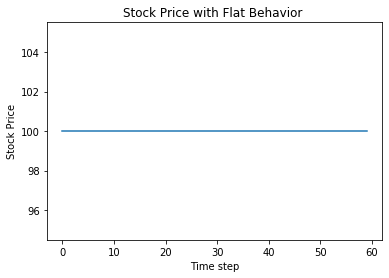

In [0]:
flat_stock = pd.read_csv("/content/drive/Shared drives/Algorithmic Trading/Test Time Series/flat.csv")
flat_stock.drop("Unnamed: 0", axis=1, inplace=True)
plt.plot(flat_stock)
plt.ylabel("Stock Price")
plt.xlabel("Time step")
plt.title("Stock Price with Flat Behavior ")

Text(0.5, 1.0, 'Stock Price with Negative Drift Behavior ')

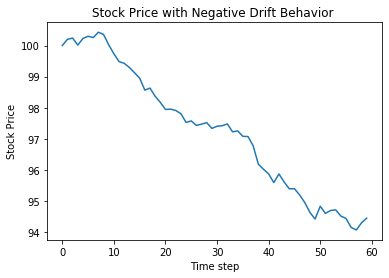

In [0]:
neg_stock = pd.read_csv("/content/drive/Shared drives/Algorithmic Trading/Test Time Series/negdrift_1.csv")
neg_stock.drop("Unnamed: 0", axis=1, inplace=True)
plt.plot(neg_stock)
plt.ylabel("Stock Price")
plt.xlabel("Time step")
plt.title("Stock Price with Negative Drift Behavior ")

Text(0.5, 1.0, 'Stock Price with Positive Drift Behavior ')

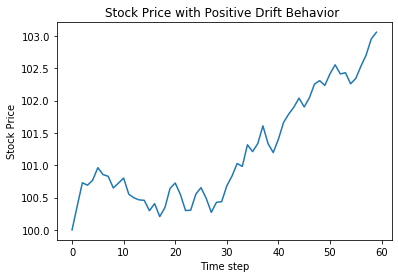

In [0]:
pos_stock = pd.read_csv("/content/drive/Shared drives/Algorithmic Trading/Test Time Series/posdrift_1.csv")
pos_stock.drop("Unnamed: 0", axis=1, inplace=True)
plt.plot(pos_stock)
plt.ylabel("Stock Price")
plt.xlabel("Time step")
plt.title("Stock Price with Positive Drift Behavior ")

Text(0.5, 1.0, 'Stock Price with No Drift with High Volatility Behavior ')

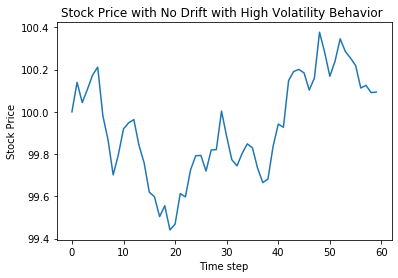

In [0]:
nodr_highvol_stock = pd.read_csv("/content/drive/Shared drives/Algorithmic Trading/Test Time Series/nodr_highvol_1.csv")
nodr_highvol_stock.drop("Unnamed: 0", axis=1, inplace=True)
plt.plot(nodr_highvol_stock)
plt.ylabel("Stock Price")
plt.xlabel("Time step")
plt.title("Stock Price with No Drift with High Volatility Behavior ")

Text(0.5, 1.0, 'Stock Price with No Drift with Low Volatility Behavior ')

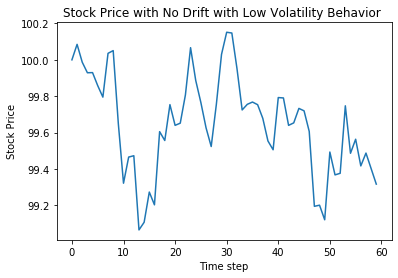

In [0]:
nodr_lowvol_stock = pd.read_csv("/content/drive/Shared drives/Algorithmic Trading/Test Time Series/nodr_lowvol_1.csv")
nodr_lowvol_stock.drop("Unnamed: 0", axis=1, inplace=True)
plt.plot(nodr_lowvol_stock)
plt.ylabel("Stock Price")
plt.xlabel("Time step")
plt.title("Stock Price with No Drift with Low Volatility Behavior ")

#Flat Stock Price Comparison

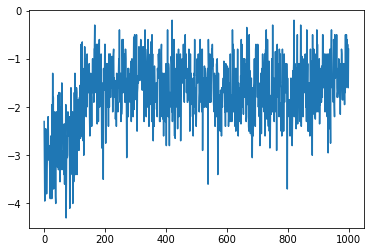

In [0]:
agent = Agent(alpha=0.0001, beta=0.00005, n_actions=7)
max_num_episodes = 1000
max_num_steps_per_episode = 60
starting_balance = 1000
actions = 7

pnl = []
portfolio_value = [] 
for episode in range(max_num_episodes):
    portfolio_value_for_episode = []
    state = State(starting_balance, 0, flat_stock.values.reshape((60,)), t=0) 
    
    for t in range(max_num_steps_per_episode-1):
        portfolio_value_for_episode.append(state.get_portfolio_value())
        action = agent.choose_action(state, t)
        #print(action)
        new_state, reward = state.update_state(action)
        agent.learn(state, action, reward, new_state, t)
        state = new_state
    
    portfolio_value.append(portfolio_value_for_episode)
    
    pnl_at_end_of_episode = state.get_portfolio_value()-starting_balance
    pnl.append(pnl_at_end_of_episode)
    #plt.plot(range(episode+1), pnl)
    #plt.ylabel("Profit or Loss")
    #plt.xlabel("Episode")
    #plt.pause(0.0001)
    #display.clear_output(wait=True)
plt.plot(range(max_num_episodes),pnl)

In [0]:
def get_risk(portfolio_value_list):
  pvl = np.array(portfolio_value_list)
  std = np.std(pd.DataFrame(pvl[-1]).pct_change(axis=0).values.flatten()[1:])
  profit = pvl[-1,-1]/pvl[-1,0]-1
  return profit, std 

def compare_to_base(start_balance, stock_prices):
  start_price = stock_prices[0]
  end_price = stock_prices[-1]
  num_shares_to_hold = start_balance//start_price
  rem_balance = start_balance - num_shares_to_hold * start_price
  position_value_at_end = num_shares_to_hold * end_price
  profit_or_loss = position_value_at_end/start_balance -1
  
  stock_returns = []
  portfolio_value = start_balance
  for price in stock_prices[1:]:
    new_portfolio_value = rem_balance + num_shares_to_hold * price
    stock_returns.append(new_portfolio_value/portfolio_value - 1)
    portfolio_value = new_portfolio_value
  
  std = np.std(np.array(stock_returns))
  return profit_or_loss, std

In [0]:
print(get_risk(portfolio_value))
print(compare_to_base(1000, flat_stock.values.reshape((60,))))

(-0.0007999999999999119, 3.690807804474188e-05)
(0.0, 0.0)


#Neg Stock Price Comparison

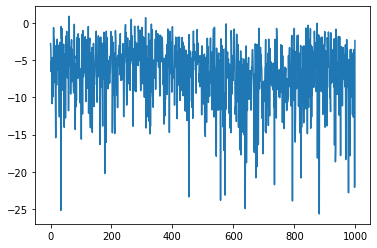

In [0]:
pnl = []
portfolio_value = [] 
for episode in range(max_num_episodes):
    portfolio_value_for_episode = []
    state = State(starting_balance, 0, neg_stock.values.reshape((60,)), t=0)
    
    for t in range(max_num_steps_per_episode-1):
        portfolio_value_for_episode.append(state.get_portfolio_value())
        action = agent.choose_action(state, t)
        #print(action)
        new_state, reward = state.update_state(action)
        agent.learn(state, action, reward, new_state, t)
        state = new_state
    
    portfolio_value.append(portfolio_value_for_episode)
    
    pnl_at_end_of_episode = state.get_portfolio_value()-starting_balance
    pnl.append(pnl_at_end_of_episode)
    #plt.plot(range(episode+1), pnl)
    #plt.ylabel("Profit or Loss")
    #plt.xlabel("Episode")
    #plt.pause(0.0001)
    #display.clear_output(wait=True)
plt.plot(range(max_num_episodes),pnl)

In [0]:
print(get_risk(portfolio_value))
print(compare_to_base(1000, neg_stock.values.reshape((60,))))

(-0.0024003704226601696, 0.0001375468353840391)
(-0.05554266345557701, 0.001902690911344837)


#Pos Stock Price Comparison

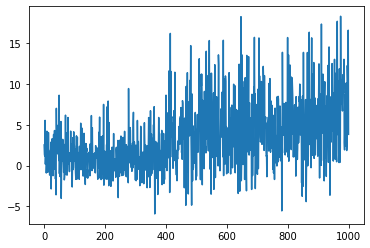

In [0]:
pnl = []
portfolio_value = [] 
for episode in range(max_num_episodes):
    portfolio_value_for_episode = []
    state = State(starting_balance, 0, pos_stock.values.reshape((60,)), t=0)
    
    for t in range(max_num_steps_per_episode-1):
        portfolio_value_for_episode.append(state.get_portfolio_value())
        action = agent.choose_action(state, t)
        #print(action)
        new_state, reward = state.update_state(action)
        agent.learn(state, action, reward, new_state, t)
        state = new_state
    
    portfolio_value.append(portfolio_value_for_episode)
    
    pnl_at_end_of_episode = state.get_portfolio_value()-starting_balance
    pnl.append(pnl_at_end_of_episode)
    #plt.plot(range(episode+1), pnl)
    #plt.ylabel("Profit or Loss")
    #plt.xlabel("Episode")
    #plt.pause(0.0001)
    #display.clear_output(wait=True)
plt.plot(range(max_num_episodes),pnl)

In [0]:
print(get_risk(portfolio_value))
print(compare_to_base(1000, pos_stock.values.reshape((60,))))

(0.003309217423338673, 0.0005049797810797726)
(0.030574184918823022, 0.0016597988452812266)


# No Dr High Vol Stock Price Comparison

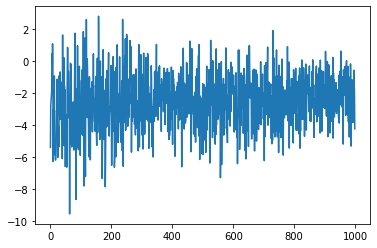

In [0]:
pnl = []
portfolio_value = [] 
for episode in range(max_num_episodes):
    portfolio_value_for_episode = []
    state = State(starting_balance, 0,nodr_highvol_stock.values.reshape((60,)), t=0)
    
    for t in range(max_num_steps_per_episode-1):
        portfolio_value_for_episode.append(state.get_portfolio_value())
        action = agent.choose_action(state, t)
        #print(action)
        new_state, reward = state.update_state(action)
        agent.learn(state, action, reward, new_state, t)
        state = new_state
    
    portfolio_value.append(portfolio_value_for_episode)
    
    pnl_at_end_of_episode = state.get_portfolio_value()-starting_balance
    pnl.append(pnl_at_end_of_episode)
    #plt.plot(range(episode+1), pnl)
    #plt.ylabel("Profit or Loss")
    #plt.xlabel("Episode")
    #plt.pause(0.0001)
    #display.clear_output(wait=True)
plt.plot(range(max_num_episodes),pnl)

In [0]:
print(get_risk(portfolio_value))
print(compare_to_base(1000, nodr_highvol_stock.values.reshape((60,))))

(-0.004172414841416949, 0.00018687508123575158)
(0.0009372303712023022, 0.0009772945993036242)


#No Dr Low Vol Stock Price Comparison

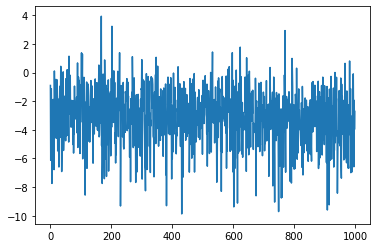

In [0]:
pnl = []
portfolio_value = [] 
for episode in range(max_num_episodes):
    portfolio_value_for_episode = []
    state = State(starting_balance, 0,nodr_lowvol_stock.values.reshape((60,)), t=0)
    
    for t in range(max_num_steps_per_episode-1):
        portfolio_value_for_episode.append(state.get_portfolio_value())
        action = agent.choose_action(state, t)
        #print(action)
        new_state, reward = state.update_state(action)
        agent.learn(state, action, reward, new_state, t)
        state = new_state
    
    portfolio_value.append(portfolio_value_for_episode)
    
    pnl_at_end_of_episode = state.get_portfolio_value()-starting_balance
    pnl.append(pnl_at_end_of_episode)
    #plt.plot(range(episode+1), pnl)
    #plt.ylabel("Profit or Loss")
    #plt.xlabel("Episode")
    #plt.pause(0.0001)
    #display.clear_output(wait=True)
plt.plot(range(max_num_episodes),pnl)

In [0]:
print(get_risk(portfolio_value))
print(compare_to_base(1000, nodr_lowvol_stock.values.reshape((60,))))

(-0.002611056349240526, 0.0005150834008281048)
(-0.006838374338332787, 0.0018133567882110118)
